# Etude de l'influence de paramètres sur l'efficacité d'attaques

In [17]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import os
from os.path import join,exists


import numpy as np
import pandas as pd
import cv2
import pickle
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt

import tensorflow as tf



from tensorflow import convert_to_tensor
import tensorflow.keras.backend as K
from tensorflow.keras.models import  load_model,Model
from tensorflow.keras import applications
from tensorflow.keras.layers import Dropout, Activation, Dense, GlobalMaxPooling2D,Conv2D,Flatten,MaxPooling2D,InputLayer
from tensorflow.keras.utils import to_categorical

from efficientnet.tfkeras import EfficientNetB7
from tensorflow.keras import datasets
from foolbox.attacks import LinfFastGradientAttack,LinfDeepFoolAttack
from foolbox.distances import LpDistance
from foolbox.models import TensorFlowModel
from foolbox import criteria
from sklearn.metrics import classification_report,plot_roc_curve

from art.attacks.evasion import SaliencyMapMethod
from art.estimators.classification import TensorFlowV2Classifier
from art.attacks.evasion import BoundaryAttack
from art.utils import load_dataset #to play with cifar images

gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_virtual_device_configuration(
    gpus[0],
    [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=6*1024)]
)


from adv_benchmark.models_training import pick_data_set,train_and_save_effnet,train_and_save_small_model
from adv_benchmark.white_box_attacks import attack_runner
from adv_benchmark.black_box_attacks import boundary_attack_run

ModuleNotFoundError: No module named 'metrics'

In [2]:
pip install adv_benchmark

Note: you may need to restart the kernel to use updated packages.


3 facteurs pouvant influencer la perfomance d'attaques adverses ont été identifié:
- **La complexité du modèle (small custom model vs efficientnet)**
- **La complexité de l'attaque**
- **La complexité et la variance interne du jeu de données**

Nous avons choisi d'étudier différent scénario pour lequel nous allons tracer à chaque fois le success rate de l'attaque en fonction du degree of change. Nous étudierons:
- **3 attaques (deepfool 1 step, deepfool mutliple steps et FGSM)**
- **2 modèles (efficientNet et small custom model)**
- **2 jeux de données (Mnist et Cifar)**

### 1. Load Data

#### Mnist

In [3]:
data_mnist=datasets.mnist.load_data(path='mnist.npz')
X_train_mnist,y_train_mnist=data_mnist[0][0],data_mnist[0][1]
X_test_mnist,y_test_mnist=data_mnist[1][0],data_mnist[1][1]
y_train_mnist = to_categorical(y_train_mnist, 10)
y_test_mnist = to_categorical(y_test_mnist, 10)

""" Train """
X_train_img_mnist = np.full((60000, 32, 32, 3), 0)
for i, s in enumerate(X_train_mnist):
    X_train_img_mnist[i] = cv2.cvtColor(np.pad(s,2), cv2.COLOR_GRAY2RGB) 
    
""" Test """
X_test_img_mnist = np.full((10000, 32, 32, 3), 0)
for i, s in enumerate(X_test_mnist):
    X_test_img_mnist[i] = cv2.cvtColor(np.pad(s,2), cv2.COLOR_GRAY2RGB) 
    
X_train_mnist=X_train_img_mnist
X_test_mnist= X_test_img_mnist

#### Cifar-10

In [4]:
(X_train_cifar, y_train_cifar), (X_test_cifar, y_test_cifar), _,_=load_dataset('cifar10')
for i, im in enumerate(X_train_cifar):
    X_train_cifar[i]=255*im
for i, im in enumerate(X_test_cifar):
    X_test_cifar[i]=255*im    


dict_classes={}
dict_classes[0]='airplane'
dict_classes[1]='automobile'
dict_classes[2]='bird'
dict_classes[3]='cat'
dict_classes[4]='deer'
dict_classes[5]='dog'
dict_classes[6]='frog'
dict_classes[7]='horse'
dict_classes[8]='ship'
dict_classes[9]='truck'

#### 2. Load models

In [5]:
def pick_data_set(name):
    
    if name=='Mnist':
        X_train=X_train_mnist
        X_test= X_test_mnist
        y_train = y_train_mnist
        y_test= y_test_mnist

    elif name=='Cifar':
        X_train=X_train_cifar
        X_test= X_test_cifar
        y_train = y_train_cifar
        y_test= y_test_cifar    
    return(X_train,X_test,y_train,y_test)
    
    

Nous allons comparer les attaques sur efficientNet,sur un petit modèle 'fait maison'  

In [6]:
def train_and_save_effnet(data_set_name):
    (X_train,X_test,y_train,y_test)=pick_data_set(data_set_name)
    tf.keras.backend.clear_session()
    effnet_base = EfficientNetB7(weights='imagenet', include_top=False, input_shape=(32, 32, 3))
    effnet_base.trainable=True
    x = GlobalMaxPooling2D(name='pool_1')(effnet_base.layers[-2].output)
    x = Dropout(0.2, name="dropout_2")(x)
    x = Dense(32)(x)
    x = Dense(10,name='fc_2')(x)
    o = Activation('softmax', name='act_2')(x)
    model_effnet = Model(inputs=effnet_base.input, outputs=[o])


    
    if exists('models/effnet_model_'+str(data_set_name)+'.h5')==False:
        model_effnet.compile(
            loss='categorical_crossentropy',
            optimizer='nadam',
            metrics=['accuracy']
            )
        history = model_effnet.fit(X_train, y_train,
                      epochs=5,
                      batch_size = 128,
                      validation_split=0.1,
                      shuffle=True,
                      verbose=1)
        model_effnet.save('models/effnet_model_'+str(data_set_name)+'.h5')

    else:
        model_effnet=load_model('models/effnet_model_'+str(data_set_name)+'.h5')
        
    return(model_effnet)
    

In [35]:
def train_and_save_small_model(data_set_name):
    
    if exists('models/small_model_'+str(data_set_name)+'.h5')==False:
        (X_train,X_test,y_train,y_test)=pick_data_set(data_set_name)
        tf.keras.backend.clear_session()   
        small_model = tf.keras.models.Sequential()
        small_model.add(Conv2D(64, (3, 3), activation='relu', input_shape=(32,32,3)))
        small_model.add(MaxPooling2D(2, 2))
        small_model.add(Conv2D(64, (3, 3), activation='relu'))
        small_model.add(MaxPooling2D(2, 2))
        small_model.add(Flatten())
        small_model.add(Dense(128, activation='relu'))
        small_model.add(Dense(10, activation='softmax'))


        small_model.compile(
            loss='categorical_crossentropy',
            optimizer='nadam',
            metrics=['accuracy']
            )


        history = small_model.fit(X_train, y_train,
                      epochs=10,
                      batch_size =128,
                      validation_split=0.1,
                      shuffle=True,
                      verbose=1)


        small_model.save('models/small_model_'+str(name)+'.h5')
    else:
        small_model=load_model('models/small_model_'+str(name)+'.h5')
    return(small_model)

In [36]:
name='Mnist'
(X_train,X_test,y_train,y_test)=pick_data_set(name)
small_model=train_and_save_small_model(name)
y_pred_small_model=[np.argmax(pred) for pred in small_model.predict(X_test)]
y_true=[np.argmax(y) for y in y_test]
classification_small_model=classification_report(y_true, y_pred_small_model)
print('performances of the small model on '+str(name))
print('-------------------------')
print(classification_small_model)

performances of the small model on Mnist
-------------------------
              precision    recall  f1-score   support

           0       0.97      1.00      0.98       980
           1       0.99      1.00      0.99      1135
           2       0.98      0.98      0.98      1032
           3       0.98      0.99      0.99      1010
           4       0.98      0.99      0.99       982
           5       0.99      0.99      0.99       892
           6       0.99      0.99      0.99       958
           7       0.99      0.98      0.98      1028
           8       0.99      0.97      0.98       974
           9       0.98      0.98      0.98      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



In [37]:
name='Mnist'
(X_train,X_test,y_train,y_test)=pick_data_set(name)
model_effnet=train_and_save_effnet(name)
y_pred_model_effnet=[np.argmax(pred) for pred in model_effnet.predict(X_test)]
y_true=[np.argmax(y) for y in y_test]
classification_small_model=classification_report(y_true, y_pred_model_effnet)
print('performances of efficientNet on '+str(name))
print('-------------------------')
print(classification_small_model)

performances of efficientNet on Mnist
-------------------------
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       980
           1       0.99      1.00      1.00      1135
           2       0.99      1.00      1.00      1032
           3       0.99      1.00      0.99      1010
           4       1.00      0.98      0.99       982
           5       1.00      0.99      0.99       892
           6       1.00      0.98      0.99       958
           7       0.99      0.99      0.99      1028
           8       0.98      1.00      0.99       974
           9       0.99      0.99      0.99      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



In [38]:
name='Cifar'
(X_train,X_test,y_train,y_test)=pick_data_set(name)
small_model=train_and_save_small_model(name)
y_pred_small_model=[np.argmax(pred) for pred in small_model.predict(X_test)]
y_true=[np.argmax(y) for y in y_test]
classification_small_model=classification_report(y_true, y_pred_small_model)
print('performances of the small model on '+str(name))
print('-------------------------')
print(classification_small_model)

performances of the small model on Cifar
-------------------------
              precision    recall  f1-score   support

           0       0.62      0.65      0.64      1000
           1       0.77      0.74      0.76      1000
           2       0.61      0.43      0.51      1000
           3       0.40      0.42      0.41      1000
           4       0.56      0.51      0.53      1000
           5       0.58      0.47      0.52      1000
           6       0.77      0.67      0.72      1000
           7       0.63      0.71      0.67      1000
           8       0.64      0.79      0.71      1000
           9       0.62      0.79      0.70      1000

    accuracy                           0.62     10000
   macro avg       0.62      0.62      0.62     10000
weighted avg       0.62      0.62      0.62     10000



In [39]:
name='Cifar'
(X_train,X_test,y_train,y_test)=pick_data_set(name)
model_effnet=train_and_save_effnet(name)
y_pred_model_effnet=[np.argmax(pred) for pred in model_effnet.predict(X_test)]
y_true=[np.argmax(y) for y in y_test]
classification_small_model=classification_report(y_true, y_pred_model_effnet)
print('performances of efficientNet on '+str(name))
print('-------------------------')
print(classification_small_model)

performances of efficientNet on Cifar
-------------------------
              precision    recall  f1-score   support

           0       0.88      0.85      0.86      1000
           1       0.92      0.91      0.92      1000
           2       0.85      0.78      0.81      1000
           3       0.72      0.69      0.70      1000
           4       0.84      0.85      0.85      1000
           5       0.77      0.77      0.77      1000
           6       0.86      0.91      0.89      1000
           7       0.88      0.91      0.89      1000
           8       0.89      0.93      0.91      1000
           9       0.89      0.91      0.90      1000

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000



#### 3. Load attacks 

contrast_enhancer permet d augmenter le bruit lorsqu il est très faible

In [8]:
def contrast_enhancer(image_noise):    
    for i in range (3):
        color_axis=image_noise[:,:,i]
        color_axis =((color_axis -np.min(color_axis))/np.ptp(color_axis))
        image_noise[:,:,i]=color_axis
    image_noise=image_noise #in order to have the darker colors corresponding to the biggest changes
    return(image_noise)

Let's define the peformances metrics

In [9]:
def DOC (x_adv_list,x_list): #degree of change
    N=len(x_adv_list)
    sum=0
    for i in range (N):        
        sum+=100*np.linalg.norm(np.reshape(x_adv_list[i] - x_list[i], -1),ord=1)/np.linalg.norm(np.reshape(x_list[i], -1),ord=1)
    return(sum/N)

def succes_rate (success_list):
    success=len([i for i in success_list if i==True])
    total=len(success_list)
    return(success/total)

In [10]:
attack_deepfool_1_steps=LinfDeepFoolAttack(steps=1)
attack_deepfool_mutliple_steps=LinfDeepFoolAttack()
attack_FGSM=LinfFastGradientAttack()

#### 5. Attacks performances

In [11]:
def black_box_attack(model_to_attack,target,iterations=150):
    classifier = TensorFlowV2Classifier(model=model_to_attack, input_shape=(32,32,3),clip_values=(0, 255),nb_classes=10)
    SR_blackbox_dic={}
    attack = BoundaryAttack(estimator=classifier, targeted=False, max_iter=0, delta=0.001, epsilon=0.001,init_size=100)
    iter_step =1
    x_adv = None
    for i in range(iterations):
        x_adv = attack.generate(x=np.array([target]), x_adv_init=x_adv)

        #clear_output()
        print("Adversarial image at step %d." % (i * iter_step), "L2 error", 
              np.linalg.norm(np.reshape(x_adv[0] - target, [-1])),
              "and class label %d." % np.argmax(classifier.predict(x_adv)[0]))
        plt.imshow(x_adv[0][..., ::-1].astype('int32'))
        plt.show(block=False)
        SR_blackbox_dic[DOC([x_adv[0]],[target])]=1

        if hasattr(attack, 'curr_delta') and hasattr(attack, 'curr_epsilon'):
            attack.max_iter = iter_step 
            attack.delta = attack.curr_delta
            attack.epsilon = attack.curr_epsilon
        else:
            break
    return(SR_blackbox_dic)


attack_performances_computer renvoit le degree of change d'une attaque et son success rate

In [12]:
def attack_performances_computer(model_to_fool,attack, image_list, labels,epsilon):
    if len(labels[0])>1:
        labels=list(map(np.argmax,labels))
    success=[]
    adv_list=[]
    attack_value=[]
    for i,image in enumerate(tqdm(image_list,position=0)):
        image = np.asarray(image)[:,:,:3].astype('float32')
        image = convert_to_tensor(np.expand_dims(image,axis=0))
        label=labels[i]
        label = tf.convert_to_tensor(np.array([label]))
        _, clipped, is_adv = attack(model_to_fool,image,label,epsilons=epsilon)
        success.append(bool(is_adv[0][0]))
        adv_list.append(np.array(clipped[0][0]))
    DOC_attack=DOC(adv_list,image_list)
    SR_attack=succes_rate(success)
    return(DOC_attack,SR_attack)

##### Comparison FGSM vs deepfool 1 step vs deepfool mutliple steps on effnet

The success rate with 5 steps is the same than with one step, however the DOC is slightly better (lower) with one step. 

In [13]:
def attack_runner(model_to_fool,image_list, labels_list, epislons_list):
    
    
    attack_deepfool_1_steps=LinfDeepFoolAttack(steps=1)
    attack_deepfool_mutliple_steps=LinfDeepFoolAttack()
    attack_FGSM=LinfFastGradientAttack()
    
    if len(labels_list[0])<=5:
        labels_list=list(map(np.argmax,labels_list))

    SR_FGSM_dic={}
    SR_deepfool_1step_dic={}
    SR_deepfool_mutliple_steps_dic={}


    for epsilon in epislons_list:
        print('======'+'epislon: '+str(epsilon)+'======')
        DOC_FGSM,SR_FGSM=attack_performances_computer(model_to_fool,attack_FGSM, image_list, labels_list,[epsilon])
        DOC_deepfool_1step,SR_deepfool_1step=attack_performances_computer(model_to_fool,attack_deepfool_1_steps, image_list, labels_list,[epsilon])
        DOC_deepfool_mutliple_steps,SR_deepfool_mutliple_steps=attack_performances_computer(model_to_fool,attack_deepfool_mutliple_steps, image_list, labels_list,[epsilon])


        SR_deepfool_1step_dic[DOC_deepfool_1step]=SR_deepfool_1step   
        SR_deepfool_mutliple_steps_dic[DOC_deepfool_mutliple_steps]=SR_deepfool_mutliple_steps    
        SR_FGSM_dic[DOC_FGSM]=SR_FGSM
        
    return(SR_deepfool_1step_dic,SR_deepfool_mutliple_steps_dic,SR_FGSM_dic)

Epoch 1/10
422/422 [==============================] - 3s 8ms/step - loss: 1.0336 - accuracy: 0.9269 - val_loss: 0.1020 - val_accuracy: 0.9717
Epoch 2/10
422/422 [==============================] - 3s 7ms/step - loss: 0.0646 - accuracy: 0.9799 - val_loss: 0.0647 - val_accuracy: 0.9812
Epoch 3/10
422/422 [==============================] - 3s 7ms/step - loss: 0.0380 - accuracy: 0.9878 - val_loss: 0.0514 - val_accuracy: 0.9878
Epoch 4/10
422/422 [==============================] - 3s 7ms/step - loss: 0.0275 - accuracy: 0.9908 - val_loss: 0.0502 - val_accuracy: 0.9873
Epoch 5/10
422/422 [==============================] - 3s 7ms/step - loss: 0.0255 - accuracy: 0.9920 - val_loss: 0.0556 - val_accuracy: 0.9872
Epoch 6/10
422/422 [==============================] - 3s 7ms/step - loss: 0.0223 - accuracy: 0.9926 - val_loss: 0.0627 - val_accuracy: 0.9868
Epoch 7/10
422/422 [==============================] - 3s 7ms/step - loss: 0.0229 - accuracy: 0.9929 - val_loss: 0.0732 - val_accuracy: 0.9875
Epoch 

 10%|█         | 10/100 [00:00<00:00, 95.78it/s]

======epislon: 0.1======


 16%|█▌        | 16/100 [00:00<00:00, 150.17it/s]

======epislon: 1======


 15%|█▌        | 15/100 [00:00<00:00, 149.86it/s]

======epislon: 5======


 16%|█▌        | 16/100 [00:00<00:00, 151.69it/s]

======epislon: 10======


 16%|█▌        | 16/100 [00:00<00:00, 151.70it/s]

======epislon: 25======


 15%|█▌        | 15/100 [00:00<00:00, 149.71it/s]

======epislon: 50======


 16%|█▌        | 16/100 [00:00<00:00, 150.94it/s]

======epislon: 75======


 15%|█▌        | 15/100 [00:00<00:00, 149.98it/s]

======epislon: 100======


Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 397.26it/s]


Adversarial image at step 0. L2 error 7972.793154150163 and class label 6.


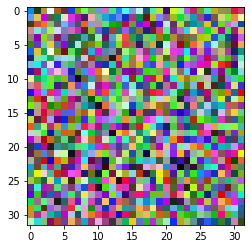

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 13.43it/s]

Adversarial image at step 1. L2 error 7964.731549579244 and class label 6.


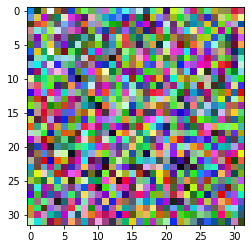

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 13.33it/s]


Adversarial image at step 2. L2 error 7952.511818103163 and class label 6.


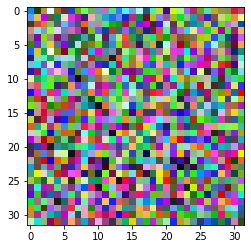

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 13.62it/s]


Adversarial image at step 3. L2 error 7934.8477618853685 and class label 6.


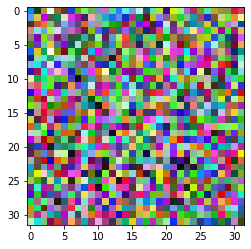

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 13.58it/s]


Adversarial image at step 4. L2 error 7908.087664909114 and class label 6.


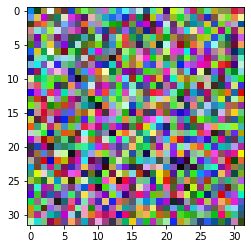

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 13.39it/s]


Adversarial image at step 5. L2 error 7868.020485491612 and class label 6.


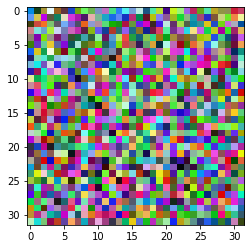

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 13.46it/s]


Adversarial image at step 6. L2 error 7808.367489385724 and class label 6.


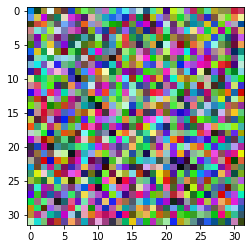

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 13.40it/s]


Adversarial image at step 7. L2 error 7719.113697345173 and class label 6.


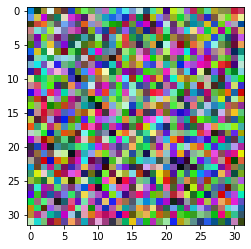

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 13.44it/s]


Adversarial image at step 8. L2 error 7586.76841450969 and class label 6.


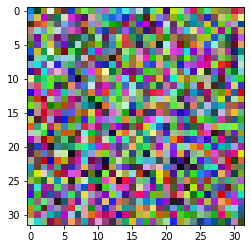

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 13.36it/s]


Adversarial image at step 9. L2 error 7391.794306541522 and class label 6.


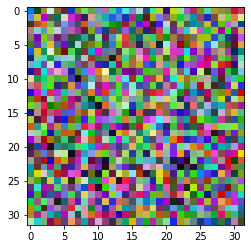

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 14.00it/s]


Adversarial image at step 10. L2 error 7110.848838653521 and class label 6.


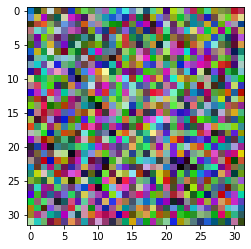

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 13.96it/s]


Adversarial image at step 11. L2 error 6700.954749325551 and class label 6.


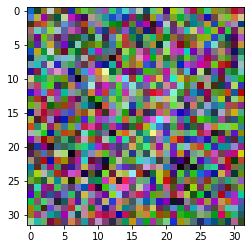

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 14.09it/s]

Adversarial image at step 12. L2 error 6123.35367534702 and class label 6.


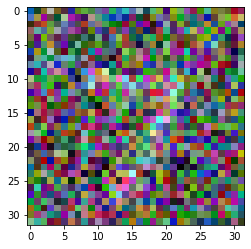

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 15.60it/s]


Adversarial image at step 13. L2 error 5329.976579131429 and class label 6.


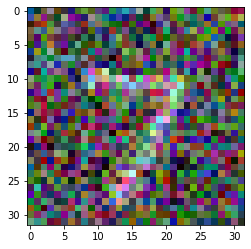

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 16.35it/s]


Adversarial image at step 14. L2 error 5018.393028862288 and class label 6.


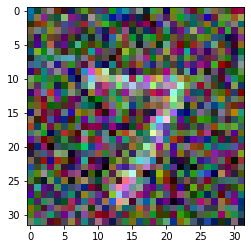

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 17.22it/s]


Adversarial image at step 15. L2 error 4719.474757027096 and class label 6.


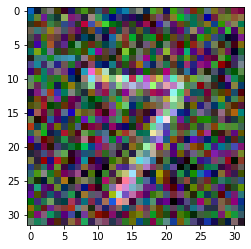

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 18.15it/s]


Adversarial image at step 16. L2 error 4306.494539784507 and class label 6.


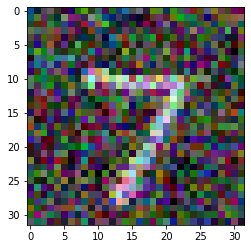

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 16.76it/s]


Adversarial image at step 17. L2 error 3918.778170647421 and class label 6.


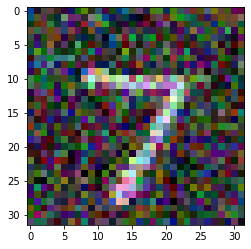

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 20.26it/s]


Adversarial image at step 18. L2 error 3732.429483185195 and class label 6.


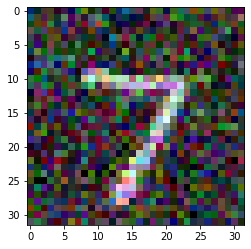

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 18.18it/s]


Adversarial image at step 19. L2 error 3654.5055208084023 and class label 6.


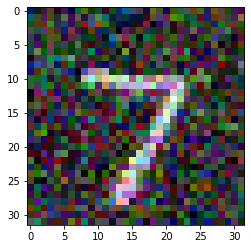

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 11.45it/s]


Adversarial image at step 20. L2 error 3589.79825570896 and class label 6.


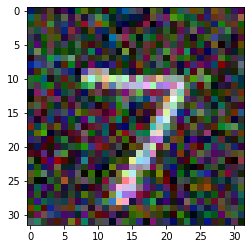

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 17.33it/s]


Adversarial image at step 21. L2 error 3526.966732149501 and class label 6.


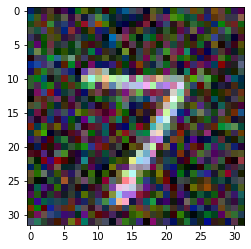

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 21.88it/s]


Adversarial image at step 22. L2 error 3466.363091086342 and class label 6.


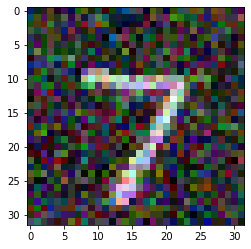

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 17.36it/s]


Adversarial image at step 23. L2 error 3408.7529042337487 and class label 6.


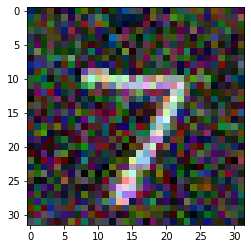

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 18.45it/s]


Adversarial image at step 24. L2 error 3354.392811677236 and class label 6.


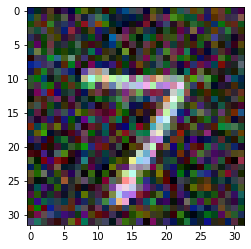

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 15.56it/s]


Adversarial image at step 25. L2 error 3292.335845339923 and class label 6.


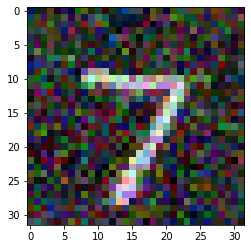

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 20.38it/s]


Adversarial image at step 26. L2 error 3240.3466403720954 and class label 6.


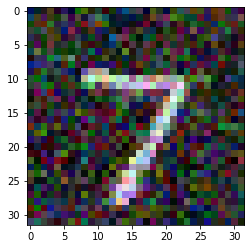

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 19.51it/s]


Adversarial image at step 27. L2 error 3205.8948910283734 and class label 6.


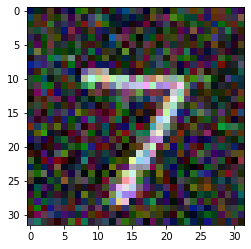

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 19.73it/s]


Adversarial image at step 28. L2 error 3167.2726903827006 and class label 6.


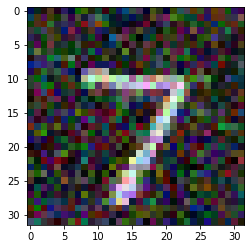

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 21.53it/s]


Adversarial image at step 29. L2 error 3131.7677833343846 and class label 6.


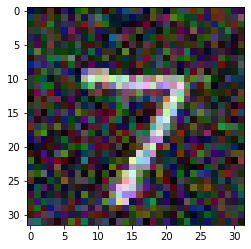

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 17.36it/s]


Adversarial image at step 30. L2 error 3098.6386599992343 and class label 6.


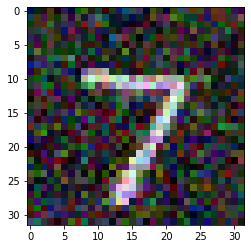

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 19.70it/s]


Adversarial image at step 31. L2 error 3065.3681705979743 and class label 6.


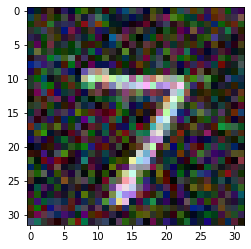

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 16.87it/s]


Adversarial image at step 32. L2 error 3042.8189809249743 and class label 6.


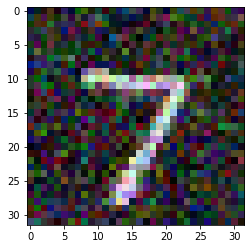

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 22.58it/s]


Adversarial image at step 33. L2 error 3032.9563041981955 and class label 6.


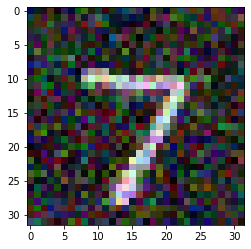

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 19.71it/s]


Adversarial image at step 34. L2 error 3018.2752616528765 and class label 6.


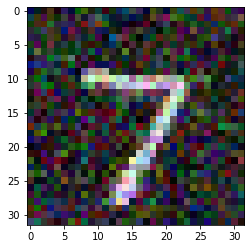

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 17.40it/s]


Adversarial image at step 35. L2 error 3009.6892388411093 and class label 6.


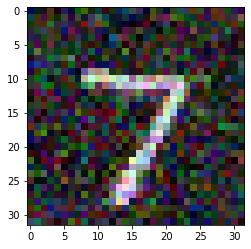

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 20.91it/s]


Adversarial image at step 36. L2 error 2999.092198916942 and class label 6.


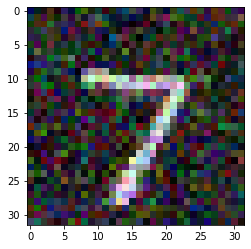

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 17.95it/s]


Adversarial image at step 37. L2 error 2990.082631482731 and class label 6.


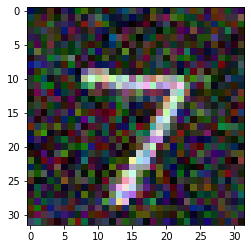

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 14.73it/s]


Adversarial image at step 38. L2 error 2979.06646843582 and class label 6.


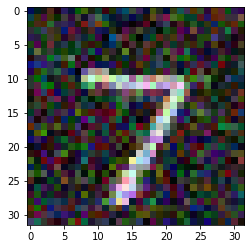

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 19.05it/s]


Adversarial image at step 39. L2 error 2973.5425209259784 and class label 6.


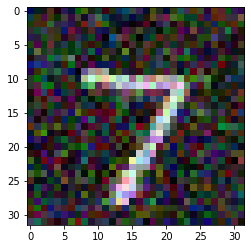

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 15.57it/s]


Adversarial image at step 40. L2 error 2962.2605855496554 and class label 6.


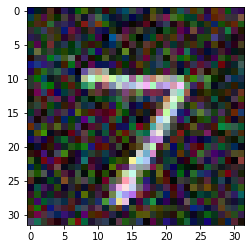

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 20.45it/s]


Adversarial image at step 41. L2 error 2949.8805827511133 and class label 6.


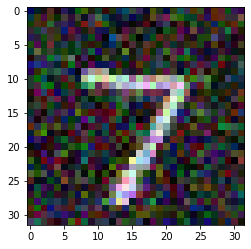

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 17.26it/s]


Adversarial image at step 42. L2 error 2938.0788688511784 and class label 6.


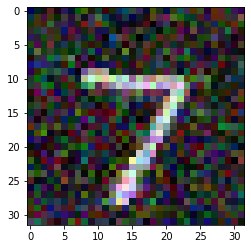

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 14.07it/s]


Adversarial image at step 43. L2 error 2914.9102451061412 and class label 6.


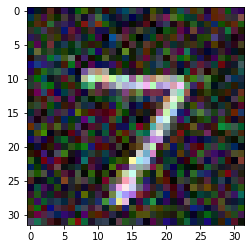

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 21.09it/s]


Adversarial image at step 44. L2 error 2891.098571026172 and class label 6.


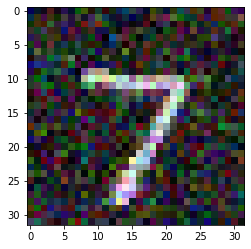

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 16.47it/s]


Adversarial image at step 45. L2 error 2862.778328865895 and class label 6.


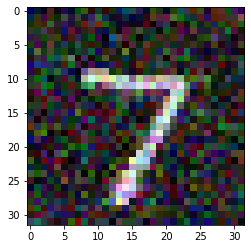

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 23.56it/s]


Adversarial image at step 46. L2 error 2827.767048128096 and class label 6.


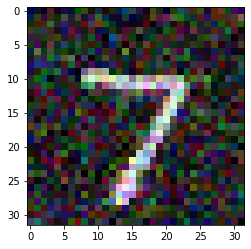

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 20.82it/s]

Adversarial image at step 47. L2 error 2798.2643303408513 and class label 6.


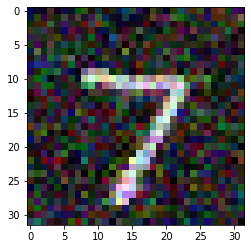

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 20.46it/s]


Adversarial image at step 48. L2 error 2765.820154037322 and class label 6.


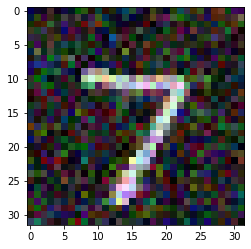

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 20.05it/s]


Adversarial image at step 49. L2 error 2730.9462529760503 and class label 6.


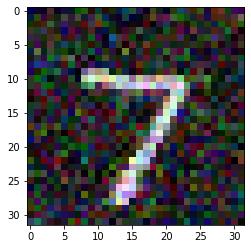

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 12.13it/s]

Adversarial image at step 50. L2 error 2725.4754376242495 and class label 6.


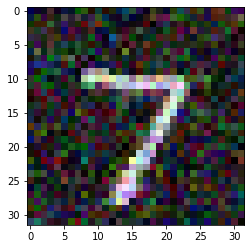

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 19.94it/s]


Adversarial image at step 51. L2 error 2718.9846683043347 and class label 6.


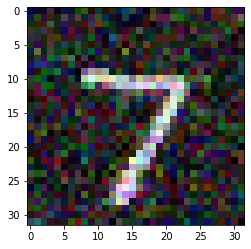

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 20.09it/s]


Adversarial image at step 52. L2 error 2708.8809089733854 and class label 6.


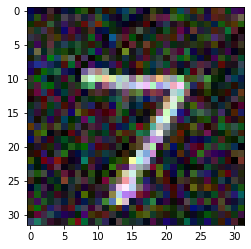

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 21.31it/s]


Adversarial image at step 53. L2 error 2705.281551711652 and class label 6.


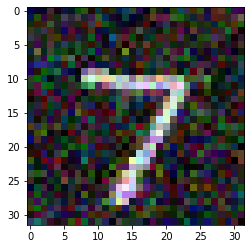

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 20.38it/s]


Adversarial image at step 54. L2 error 2701.1617941918576 and class label 6.


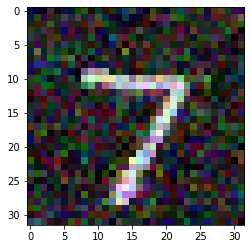

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 19.36it/s]


Adversarial image at step 55. L2 error 2697.1122062273785 and class label 6.


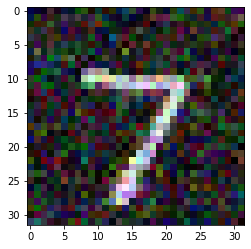

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 15.69it/s]


Adversarial image at step 56. L2 error 2690.1868821183534 and class label 6.


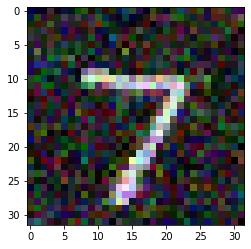

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 20.65it/s]


Adversarial image at step 57. L2 error 2682.0588842599896 and class label 6.


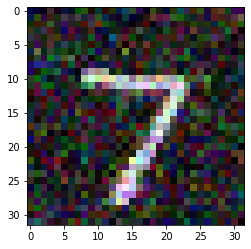

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 17.23it/s]


Adversarial image at step 58. L2 error 2673.232425184678 and class label 6.


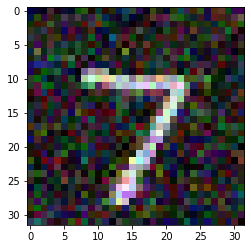

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 20.65it/s]


Adversarial image at step 59. L2 error 2665.0762263649985 and class label 6.


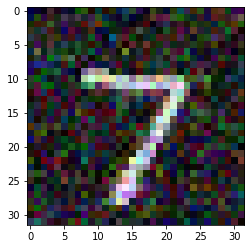

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 18.67it/s]


Adversarial image at step 60. L2 error 2651.948688206445 and class label 6.


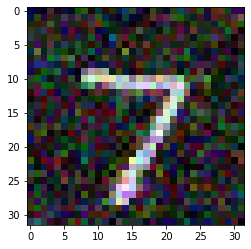

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 20.62it/s]


Adversarial image at step 61. L2 error 2642.5082198830783 and class label 6.


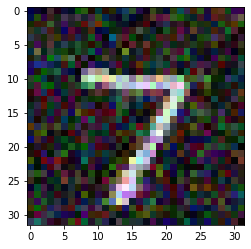

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 17.65it/s]


Adversarial image at step 62. L2 error 2634.8056806839923 and class label 6.


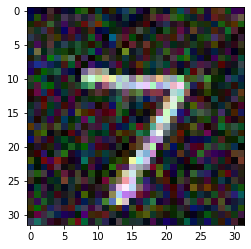

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 19.32it/s]


Adversarial image at step 63. L2 error 2621.141338901102 and class label 6.


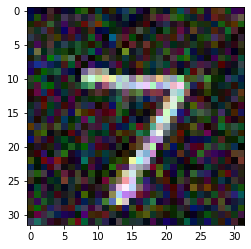

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 20.02it/s]


Adversarial image at step 64. L2 error 2604.276514007223 and class label 6.


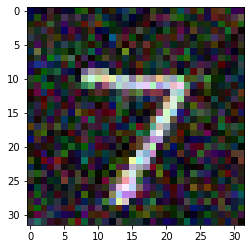

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 18.58it/s]


Adversarial image at step 65. L2 error 2604.7509654608307 and class label 6.


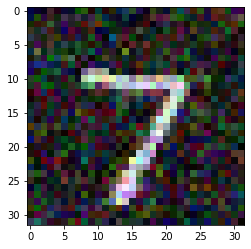

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 23.42it/s]


Adversarial image at step 66. L2 error 2604.0685678893055 and class label 6.


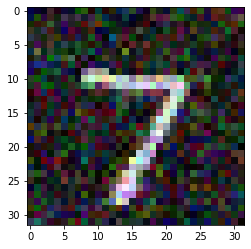

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 17.25it/s]


Adversarial image at step 67. L2 error 2602.332901358083 and class label 6.


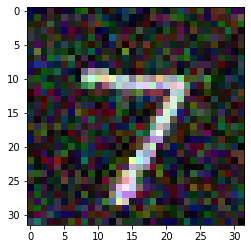

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 20.55it/s]


Adversarial image at step 68. L2 error 2598.4266332438638 and class label 6.


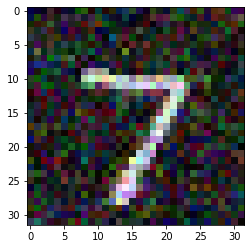

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 17.20it/s]


Adversarial image at step 69. L2 error 2592.5238535791145 and class label 6.


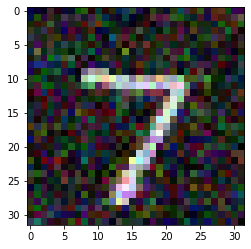

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 16.69it/s]


Adversarial image at step 70. L2 error 2586.270524532824 and class label 6.


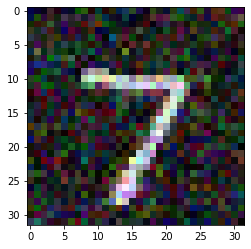

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 21.87it/s]


Adversarial image at step 71. L2 error 2582.573911590564 and class label 6.


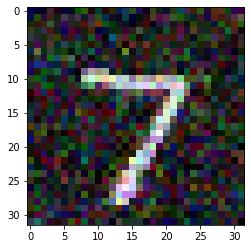

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 20.04it/s]


Adversarial image at step 72. L2 error 2579.2418301860944 and class label 6.


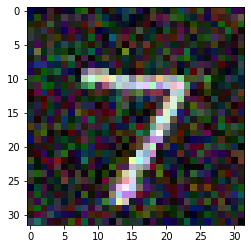

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 16.65it/s]


Adversarial image at step 73. L2 error 2573.270398118266 and class label 6.


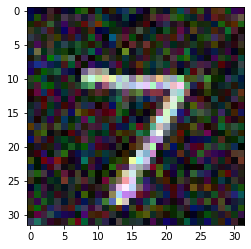

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 17.20it/s]


Adversarial image at step 74. L2 error 2567.7775223762496 and class label 6.


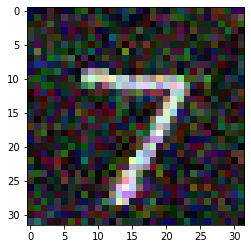

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 17.97it/s]


Adversarial image at step 75. L2 error 2563.025393983436 and class label 6.


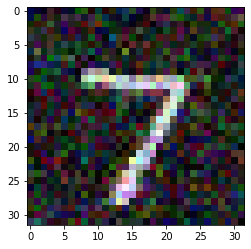

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 18.28it/s]


Adversarial image at step 76. L2 error 2554.4532281120096 and class label 6.


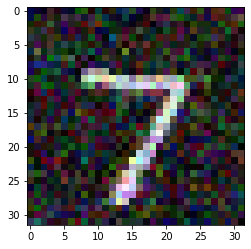

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 18.97it/s]


Adversarial image at step 77. L2 error 2546.177153483016 and class label 6.


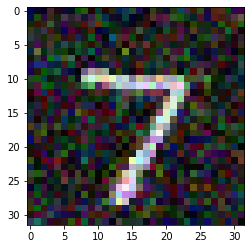

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 20.66it/s]


Adversarial image at step 78. L2 error 2532.5273391129635 and class label 6.


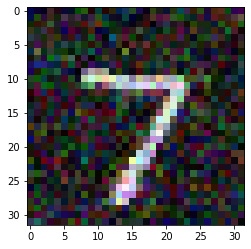

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 20.18it/s]


Adversarial image at step 79. L2 error 2523.409086802364 and class label 6.


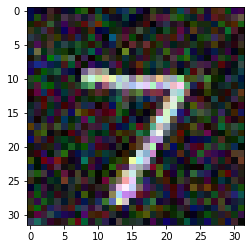

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 20.78it/s]


Adversarial image at step 80. L2 error 2514.3051079970905 and class label 6.


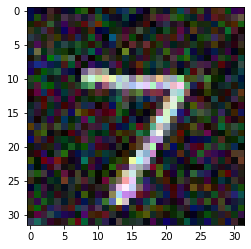

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 21.57it/s]


Adversarial image at step 81. L2 error 2505.506609727054 and class label 6.


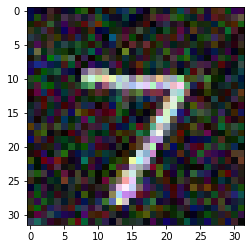

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 17.89it/s]

Adversarial image at step 82. L2 error 2497.228211426941 and class label 6.


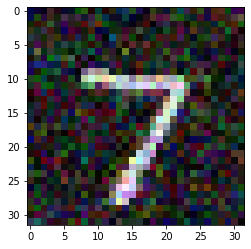

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 16.78it/s]


Adversarial image at step 83. L2 error 2493.582251947248 and class label 6.


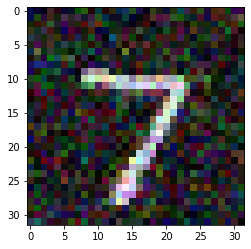

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 19.45it/s]


Adversarial image at step 84. L2 error 2490.583271299661 and class label 6.


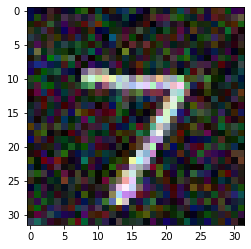

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 15.10it/s]


Adversarial image at step 85. L2 error 2487.2163086775236 and class label 6.


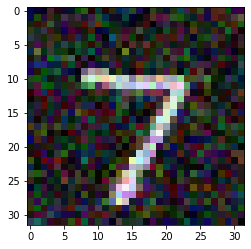

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 18.79it/s]


Adversarial image at step 86. L2 error 2481.94953374201 and class label 6.


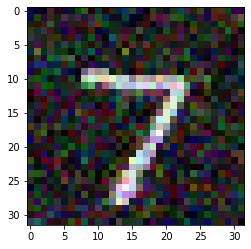

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 18.27it/s]


Adversarial image at step 87. L2 error 2477.836917274736 and class label 6.


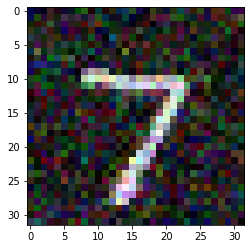

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 20.11it/s]


Adversarial image at step 88. L2 error 2474.1601937039864 and class label 6.


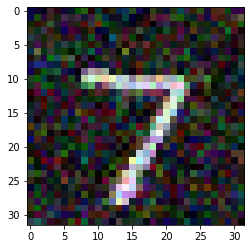

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 18.74it/s]


Adversarial image at step 89. L2 error 2470.504187387958 and class label 6.


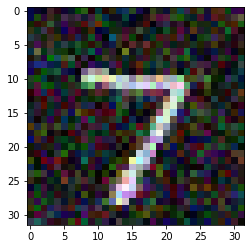

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 18.28it/s]


Adversarial image at step 90. L2 error 2467.4176406224115 and class label 6.


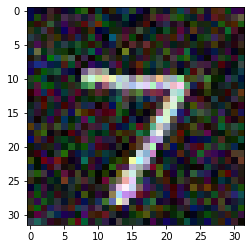

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 19.59it/s]


Adversarial image at step 91. L2 error 2462.932437789268 and class label 6.


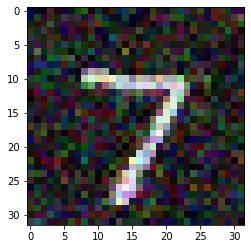

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 16.81it/s]


Adversarial image at step 92. L2 error 2457.096024715478 and class label 6.


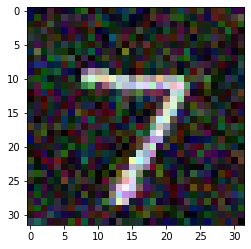

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 11.18it/s]


Adversarial image at step 93. L2 error 2450.7393452789406 and class label 6.


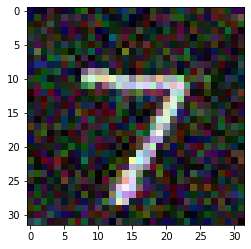

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 15.46it/s]


Adversarial image at step 94. L2 error 2442.035309065562 and class label 6.


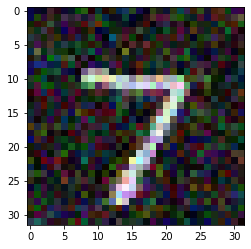

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 16.67it/s]


Adversarial image at step 95. L2 error 2436.835606490496 and class label 6.


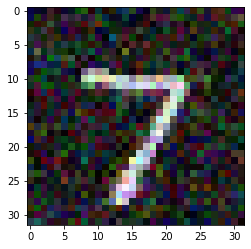

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 23.03it/s]


Adversarial image at step 96. L2 error 2431.840882664205 and class label 6.


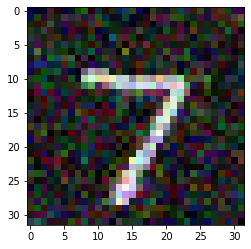

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 15.49it/s]


Adversarial image at step 97. L2 error 2426.319716055175 and class label 6.


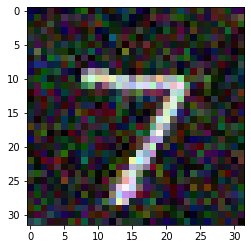

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 19.74it/s]


Adversarial image at step 98. L2 error 2415.665451398456 and class label 6.


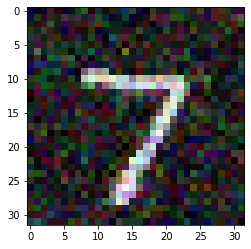

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 17.41it/s]


Adversarial image at step 99. L2 error 2401.6907555238636 and class label 6.


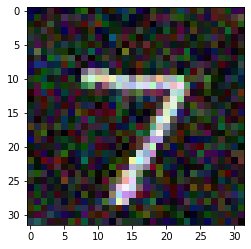

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 17.61it/s]


Adversarial image at step 100. L2 error 2396.018767942215 and class label 6.


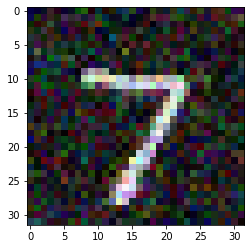

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 21.10it/s]


Adversarial image at step 101. L2 error 2392.0422876814177 and class label 6.


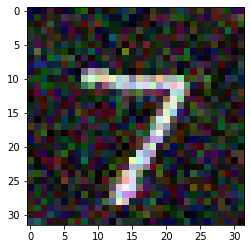

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 18.39it/s]


Adversarial image at step 102. L2 error 2387.1867261493912 and class label 6.


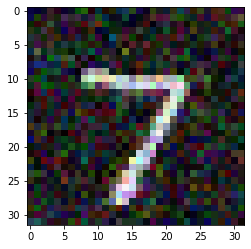

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 19.64it/s]


Adversarial image at step 103. L2 error 2382.309114230147 and class label 6.


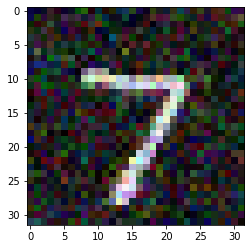

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 15.45it/s]


Adversarial image at step 104. L2 error 2373.866963629773 and class label 6.


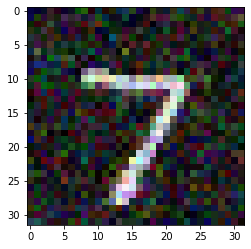

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 21.22it/s]


Adversarial image at step 105. L2 error 2367.9365414188137 and class label 6.


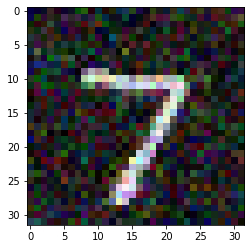

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 22.58it/s]


Adversarial image at step 106. L2 error 2363.0346462230304 and class label 6.


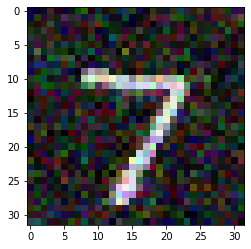

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 18.96it/s]


Adversarial image at step 107. L2 error 2353.5888319837854 and class label 6.


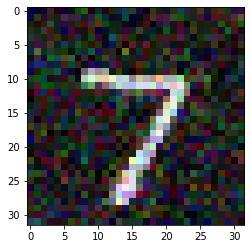

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 17.17it/s]


Adversarial image at step 108. L2 error 2347.545049138976 and class label 6.


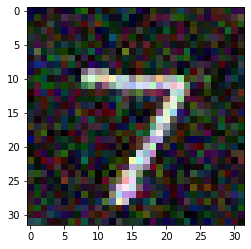

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 18.21it/s]


Adversarial image at step 109. L2 error 2342.948556600547 and class label 6.


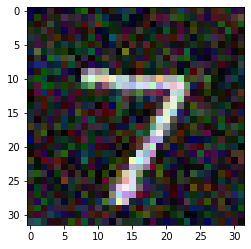

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 21.03it/s]


Adversarial image at step 110. L2 error 2334.4074044869426 and class label 6.


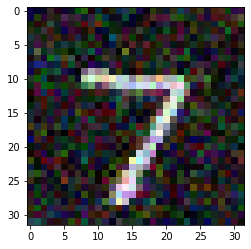

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 20.35it/s]


Adversarial image at step 111. L2 error 2326.0451841365 and class label 6.


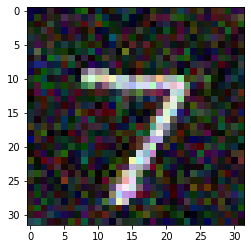

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 21.07it/s]


Adversarial image at step 112. L2 error 2317.616997425871 and class label 6.


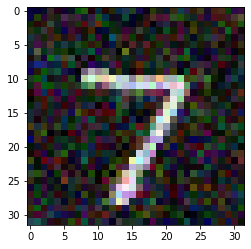

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 16.34it/s]


Adversarial image at step 113. L2 error 2314.3691250671554 and class label 6.


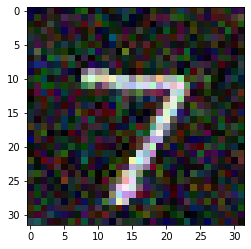

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 19.73it/s]


Adversarial image at step 114. L2 error 2311.3689335914805 and class label 6.


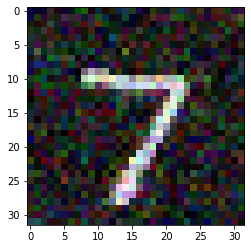

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 15.01it/s]


Adversarial image at step 115. L2 error 2306.3105483360623 and class label 6.


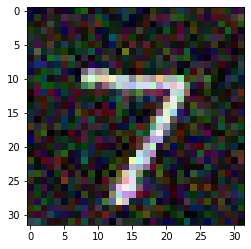

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 19.17it/s]


Adversarial image at step 116. L2 error 2302.9777863289223 and class label 6.


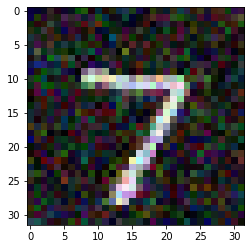

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 17.22it/s]

Adversarial image at step 117. L2 error 2298.7542180853184 and class label 6.


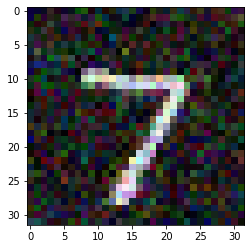

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 19.41it/s]


Adversarial image at step 118. L2 error 2297.089557700508 and class label 6.


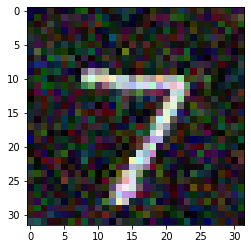

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 17.21it/s]


Adversarial image at step 119. L2 error 2291.9337104670235 and class label 6.


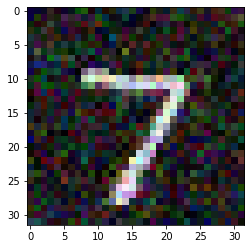

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 17.72it/s]


Adversarial image at step 120. L2 error 2286.802830742979 and class label 6.


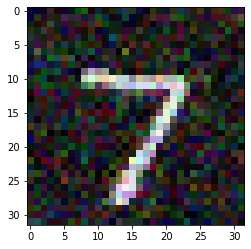

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 16.41it/s]


Adversarial image at step 121. L2 error 2281.266138149534 and class label 6.


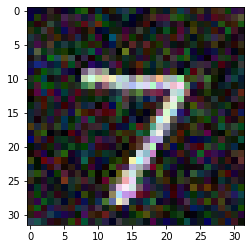

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 18.29it/s]


Adversarial image at step 122. L2 error 2276.4668460500648 and class label 6.


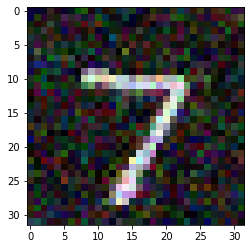

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 15.09it/s]


Adversarial image at step 123. L2 error 2271.465772856659 and class label 6.


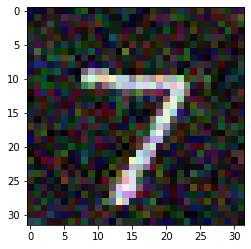

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 17.49it/s]


Adversarial image at step 124. L2 error 2264.346260447165 and class label 6.


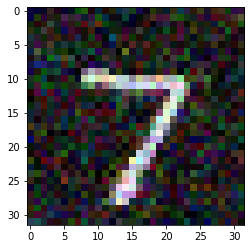

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 19.00it/s]


Adversarial image at step 125. L2 error 2257.608511459878 and class label 6.


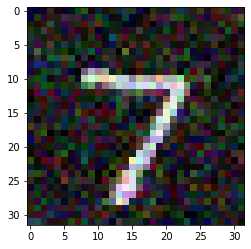

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 20.54it/s]


Adversarial image at step 126. L2 error 2256.6164381213534 and class label 6.


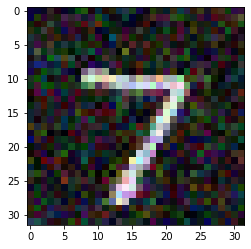

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 20.29it/s]


Adversarial image at step 127. L2 error 2254.4745904533806 and class label 6.


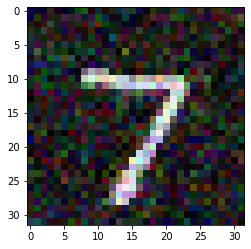

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 15.97it/s]


Adversarial image at step 128. L2 error 2251.8433198572475 and class label 6.


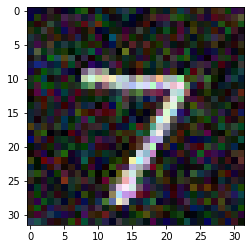

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 20.70it/s]


Adversarial image at step 129. L2 error 2248.4838545953085 and class label 6.


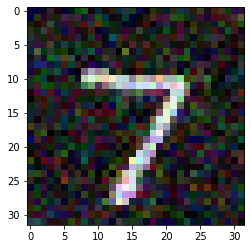

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 18.94it/s]


Adversarial image at step 130. L2 error 2245.017259623794 and class label 6.


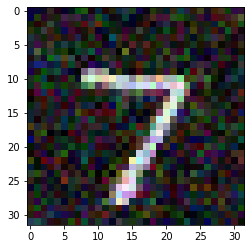

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 18.37it/s]


Adversarial image at step 131. L2 error 2239.869921998217 and class label 6.


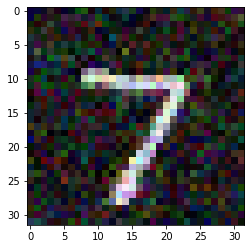

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 18.57it/s]


Adversarial image at step 132. L2 error 2233.9968949664944 and class label 6.


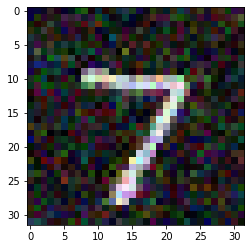

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 16.78it/s]


Adversarial image at step 133. L2 error 2229.469211403997 and class label 6.


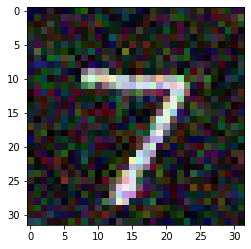

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 11.28it/s]


Adversarial image at step 134. L2 error 2224.765276446854 and class label 6.


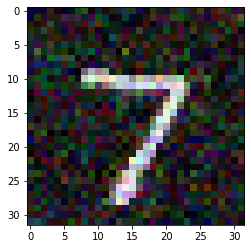

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 18.11it/s]


Adversarial image at step 135. L2 error 2221.683751066221 and class label 6.


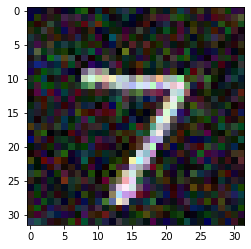

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 20.12it/s]


Adversarial image at step 136. L2 error 2219.4383183265895 and class label 6.


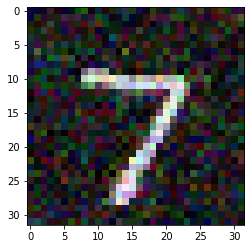

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 13.36it/s]


Adversarial image at step 137. L2 error 2216.048825671135 and class label 6.


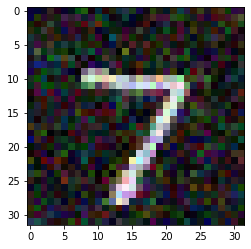

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 21.52it/s]


Adversarial image at step 138. L2 error 2211.047328251891 and class label 6.


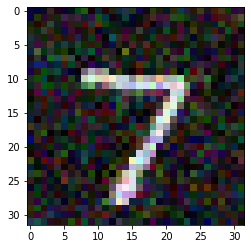

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 16.70it/s]


Adversarial image at step 139. L2 error 2206.6662890676375 and class label 6.


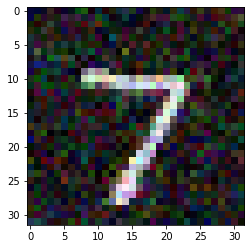

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 14.83it/s]


Adversarial image at step 140. L2 error 2204.9353241784524 and class label 6.


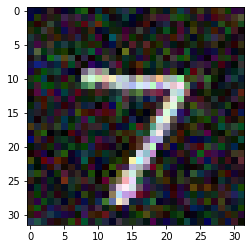

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 23.60it/s]


Adversarial image at step 141. L2 error 2204.730638631208 and class label 6.


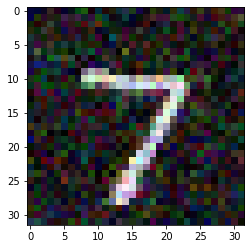

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 14.36it/s]


Adversarial image at step 142. L2 error 2203.3289442478413 and class label 6.


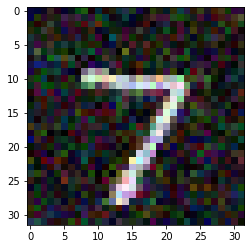

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 15.86it/s]


Adversarial image at step 143. L2 error 2198.986105198789 and class label 6.


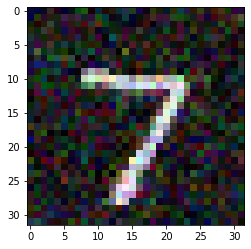

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 20.99it/s]


Adversarial image at step 144. L2 error 2194.905202478312 and class label 6.


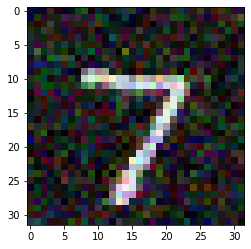

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  7.06it/s]


Adversarial image at step 145. L2 error 2193.7043951667956 and class label 6.


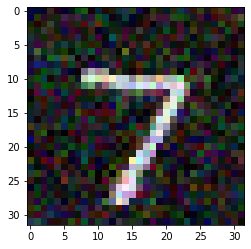

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 21.78it/s]


Adversarial image at step 146. L2 error 2191.9889250098518 and class label 6.


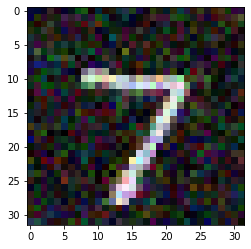

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 15.07it/s]


Adversarial image at step 147. L2 error 2189.9254178951314 and class label 6.


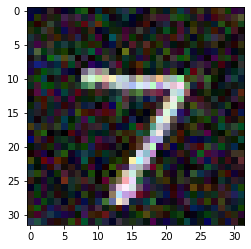

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 19.54it/s]


Adversarial image at step 148. L2 error 2187.7596844013474 and class label 6.


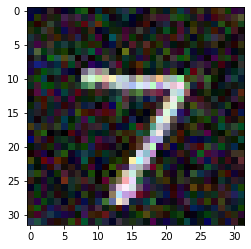

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 15.19it/s]


Adversarial image at step 149. L2 error 2186.3727461366275 and class label 6.


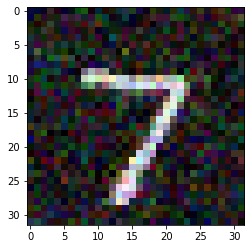

In [14]:
epsilon_list=[0.1,1,5,10,25,50,75,100]



name='Mnist'
(X_train,X_test,y_train,y_test)=pick_data_set(name)
small_model=train_and_save_small_model(name)

model_to_fool = TensorFlowModel(small_model, bounds=(0, 255))
(SR_deepfool_1step_dic_small_model,SR_deepfool_mutliple_steps_dic_small_model,SR_FGSM_dic_small_model)=attack_runner(model_to_fool,X_test[:100], y_test[:100], epsilon_list)
SR_blackbox_dic_small_model=black_box_attack(small_model,X_test[0].astype('int32'))
with open('data/perfs_models_without_defense/perfs_global_small_model_'+str(name), 'wb') as f:
    pickle.Pickler(f).dump(SR_deepfool_1step_dic_small_model)
    pickle.Pickler(f).dump(SR_deepfool_mutliple_steps_dic_small_model)
    pickle.Pickler(f).dump(SR_FGSM_dic_small_model)
    pickle.Pickler(f).dump(SR_blackbox_dic_small_model)

In [16]:
epsilon_list=[0.1,1,5,10,25,50,75,100]


name='Mnist'
(X_train,X_test,y_train,y_test)=pick_data_set(name)

model_effnet=train_and_save_effnet(name)
model_to_fool = TensorFlowModel(model_effnet,bounds=(0, 255))

(SR_deepfool_1step_dic_model_effnet,SR_deepfool_mutliple_steps_dic_model_effnet,SR_FGSM_dic_model_effnet)=attack_runner(model_to_fool,X_test[:100], y_test[:100], epsilon_list)
SR_blackbox_dic_model_effnet=black_box_attack(model_effnet,X_test[0],iterations=150)
with open('data/perfs_models_without_defense/perfs_global_model_effnet_'+str(name), 'wb') as f:
    pickle.Pickler(f).dump(SR_deepfool_1step_dic_model_effnet)
    pickle.Pickler(f).dump(SR_deepfool_mutliple_steps_dic_model_effnet)
    pickle.Pickler(f).dump(SR_FGSM_dic_model_effnet)
    pickle.Pickler(f).dump(SR_blackbox_dic_model_effnet)

Epoch 1/5
422/422 [==============================] - 113s 268ms/step - loss: 0.4147 - accuracy: 0.9126 - val_loss: 0.0344 - val_accuracy: 0.9897
Epoch 2/5
422/422 [==============================] - 109s 258ms/step - loss: 0.0820 - accuracy: 0.9789 - val_loss: 0.0325 - val_accuracy: 0.9918
Epoch 3/5
422/422 [==============================] - 109s 258ms/step - loss: 0.0435 - accuracy: 0.9888 - val_loss: 0.0368 - val_accuracy: 0.9917
Epoch 4/5
422/422 [==============================] - 109s 259ms/step - loss: 0.4818 - accuracy: 0.9599 - val_loss: 3.8890 - val_accuracy: 0.9675
Epoch 5/5
422/422 [==============================] - 109s 258ms/step - loss: 0.0800 - accuracy: 0.9792 - val_loss: 0.0383 - val_accuracy: 0.9903


  0%|          | 0/100 [00:00<?, ?it/s]

======epislon: 0.1======


 32%|███▏      | 32/100 [07:38<04:59,  4.41s/it]  

KeyboardInterrupt: 

In [ ]:
y_pred_eff=[np.argmax(pred) for pred in model_effnet.predict(X_test)]
y_true=[np.argmax(y) for y in y_test]
classification_eff=classification_report(y_true, y_pred_eff)
print('performances of effnet on '+str(name))
print('-------------------------')
print(classification_eff)

In [ ]:
tf.compat.v1.reset_default_graph()

In [ ]:
epsilon_list=[0.1,1,5,10,25,50,75,100]



name='Cifar'
(X_train,X_test,y_train,y_test)=pick_data_set(name)
small_model=train_and_save_small_model(name)

model_to_fool = TensorFlowModel(small_model, bounds=(0, 255))
(SR_deepfool_1step_dic_small_model,SR_deepfool_mutliple_steps_dic_small_model,SR_FGSM_dic_small_model)=attack_runner(model_to_fool,X_test[:100], y_test[:100], epsilon_list)
SR_blackbox_dic_small_model=black_box_attack(small_model,X_test[0])
with open('data/perfs_models_without_defense/perfs_global_small_model_'+str(name), 'wb') as f:
    pickle.Pickler(f).dump(SR_deepfool_1step_dic_small_model)
    pickle.Pickler(f).dump(SR_deepfool_mutliple_steps_dic_small_model)
    pickle.Pickler(f).dump(SR_FGSM_dic_small_model)
    pickle.Pickler(f).dump(SR_blackbox_dic_small_model)

In [ ]:
name='Cifar'
(X_train,X_test,y_train,y_test)=pick_data_set(name)
y_pred_small_model=[np.argmax(pred) for pred in small_model.predict(X_test)]
y_true=[np.argmax(y) for y in y_test]
classification_small_model=classification_report(y_true, y_pred_small_model)
print('performances of the small model on '+str(name))
print('-------------------------')
print(classification_small_model)

In [ ]:
epsilon_list=[0.1,1,5,10,25,50,75,100]

name='Cifar'
(X_train,X_test,y_train,y_test)=pick_data_set(name)

model_effnet=train_and_save_effnet(name)
model_to_fool = TensorFlowModel(model_effnet, bounds=(0, 255))

(SR_deepfool_1step_dic_model_effnet,SR_deepfool_mutliple_steps_dic_model_effnet,SR_FGSM_dic_model_effnet)=attack_runner(model_to_fool,X_test[:100], y_test[:100], epsilon_list)
SR_blackbox_dic_model_effnet=black_box_attack(model_effnet,X_test[0],iterations=150)
with open('data/perfs_models_without_defense/perfs_global_model_effnet_'+str(name), 'wb') as f:
    pickle.Pickler(f).dump(SR_deepfool_1step_dic_model_effnet)
    pickle.Pickler(f).dump(SR_deepfool_mutliple_steps_dic_model_effnet)
    pickle.Pickler(f).dump(SR_FGSM_dic_model_effnet)
    pickle.Pickler(f).dump(SR_blackbox_dic_model_effnet)

In [ ]:
y_pred_eff=[np.argmax(pred) for pred in model_effnet.predict(X_test)]
y_true=[np.argmax(y) for y in y_test]
classification_eff=classification_report(y_true, y_pred_eff)
print('performances of effnet on '+str(name))
print('-------------------------')
print(classification_eff)

In [3]:
with open('data/perfs_models_without_defense/perfs_global_small_model_Cifar', 'rb') as f:
    SR_deepfool_1step_dic_small_model_Cifar=pickle.Unpickler(f).load()
    SR_deepfool_mutliple_steps_dic_small_model_Cifar=pickle.Unpickler(f).load()
    SR_FGSM_dic_small_model_Cifar=pickle.Unpickler(f).load()
    SR_blackbox_dic_small_model_Cifar=pickle.Unpickler(f).load()
    
with open('data/perfs_models_without_defense/perfs_global_model_effnet_Cifar', 'rb') as f:
    SR_deepfool_1step_dic_model_effnet_Cifar=pickle.Unpickler(f).load()
    SR_deepfool_mutliple_steps_dic_model_effnet_Cifar=pickle.Unpickler(f).load()
    SR_FGSM_dic_model_effnet_Cifar=pickle.Unpickler(f).load()
    SR_blackbox_dic_model_effnet_Cifar=pickle.Unpickler(f).load()
    
with open('data/perfs_models_without_defense/perfs_global_small_model_Mnist', 'rb') as f:
    SR_deepfool_1step_dic_small_model_Mnist=pickle.Unpickler(f).load()
    SR_deepfool_mutliple_steps_dic_small_model_Mnist=pickle.Unpickler(f).load()
    SR_FGSM_dic_small_model_Mnist=pickle.Unpickler(f).load()
    SR_blackbox_dic_small_model_Mnist=pickle.Unpickler(f).load()
    

with open('data/perfs_models_without_defense/perfs_global_model_effnet_Mnist', 'rb') as f:
    SR_deepfool_1step_dic_model_effnet_Mnist=pickle.Unpickler(f).load()
    SR_deepfool_mutliple_steps_dic_model_effnet_Mnist=pickle.Unpickler(f).load()
    SR_FGSM_dic_model_effnet_Mnist=pickle.Unpickler(f).load()
    SR_blackbox_dic_model_effnet_Mnist=pickle.Unpickler(f).load()
    
   

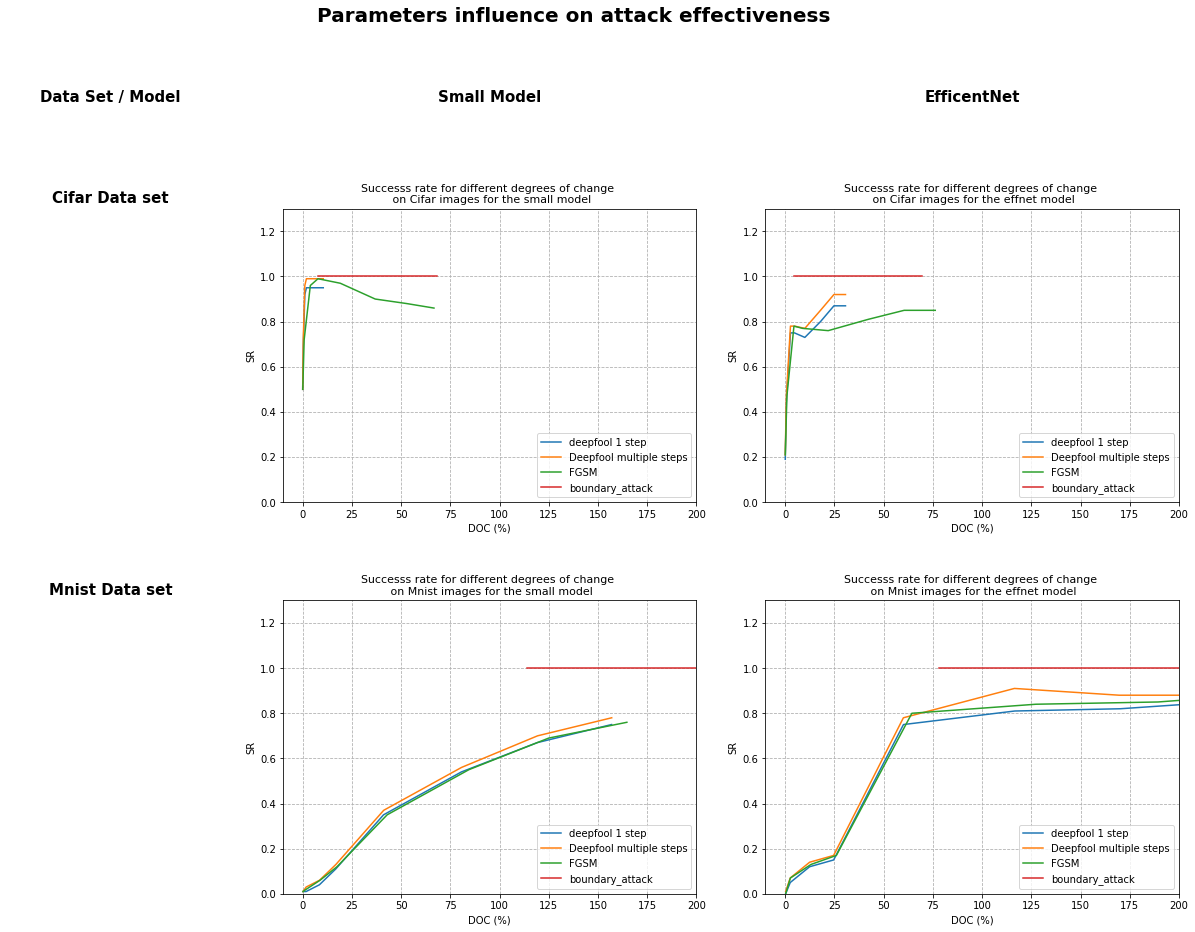

In [4]:
plt.rcParams["figure.figsize"] = 21,14
colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
fig, ax = plt.subplots(ncols=3, nrows=3, gridspec_kw={"height_ratios":[0.01,1,1],"width_ratios":[0.5,1,1]})
fig.suptitle('Parameters influence on attack effectiveness', 
             fontsize=20, fontweight='bold')


ax[0][0].axis("off")
ax[0][0].set_title("Data Set / Model", fontweight='bold',fontsize=15)


ax[0][1].axis("off")
ax[0][1].set_title("Small Model", fontweight='bold',fontsize=15)


ax[0][2].axis("off")
ax[0][2].set_title("EfficentNet", fontweight='bold',fontsize=15)


ax[1][0].axis("off")
ax[1][0].set_title("Cifar Data set", fontweight='bold',fontsize=15)



ax[2][0].axis("off")
ax[2][0].set_title("Mnist Data set", fontweight='bold',fontsize=15)


ax[1][1].plot(list(SR_deepfool_1step_dic_small_model_Cifar.keys()),list(SR_deepfool_1step_dic_small_model_Cifar.values()),label='deepfool 1 step')
ax[1][1].plot(list(SR_deepfool_mutliple_steps_dic_small_model_Cifar.keys()),list(SR_deepfool_mutliple_steps_dic_small_model_Cifar.values()),label='Deepfool multiple steps')
ax[1][1].plot(list(SR_FGSM_dic_small_model_Cifar.keys()),list(SR_FGSM_dic_small_model_Cifar.values()),label='FGSM')
ax[1][1].plot(list(SR_blackbox_dic_small_model_Cifar.keys()),list(SR_blackbox_dic_small_model_Cifar.values()),label='boundary_attack')
ax[1][1].grid(True,which="both", linestyle='--')
ax[1][1].set_title('Successs rate for different degrees of change \n on Cifar images for the small model',fontsize=11)
ax[1][1].set_xlabel('DOC (%)')
ax[1][1].set_ylabel('SR')
ax[1][1].legend(loc='lower right')
ax[1][1].set_xlim(-10,200)
ax[1][1].set_ylim(0,1.3)


ax[1][2].plot(list(SR_deepfool_1step_dic_model_effnet_Cifar.keys()),list(SR_deepfool_1step_dic_model_effnet_Cifar.values()),label='deepfool 1 step')
ax[1][2].plot(list(SR_deepfool_mutliple_steps_dic_model_effnet_Cifar.keys()),list(SR_deepfool_mutliple_steps_dic_model_effnet_Cifar.values()),label='Deepfool multiple steps')
ax[1][2].plot(list(SR_FGSM_dic_model_effnet_Cifar.keys()),list(SR_FGSM_dic_model_effnet_Cifar.values()),label='FGSM')
ax[1][2].plot(list(SR_blackbox_dic_model_effnet_Cifar.keys()),list(SR_blackbox_dic_model_effnet_Cifar.values()),label='boundary_attack')
ax[1][2].grid(True,which="both", linestyle='--')
ax[1][2].set_title('Successs rate for different degrees of change \n on Cifar images for the effnet model',fontsize=11)
ax[1][2].set_xlabel('DOC (%)')
ax[1][2].set_ylabel('SR')
ax[1][2].legend(loc='lower right')
ax[1][2].set_xlim(-10,200)
ax[1][2].set_ylim(0,1.3)



ax[2][1].plot(list(SR_deepfool_1step_dic_small_model_Mnist.keys()),list(SR_deepfool_1step_dic_small_model_Mnist.values()),label='deepfool 1 step')
ax[2][1].plot(list(SR_deepfool_mutliple_steps_dic_small_model_Mnist.keys()),list(SR_deepfool_mutliple_steps_dic_small_model_Mnist.values()),label='Deepfool multiple steps')
ax[2][1].plot(list(SR_FGSM_dic_small_model_Mnist.keys()),list(SR_FGSM_dic_small_model_Mnist.values()),label='FGSM')
ax[2][1].plot(list(SR_blackbox_dic_small_model_Mnist.keys()),list(SR_blackbox_dic_small_model_Mnist.values()),label='boundary_attack')
ax[2][1].grid(True,which="both", linestyle='--')
ax[2][1].set_title('Successs rate for different degrees of change \n on Mnist images for the small model',fontsize=11)
ax[2][1].set_xlabel('DOC (%)')
ax[2][1].set_ylabel('SR')
ax[2][1].legend(loc='lower right')
ax[2][1].set_xlim(-10,200)
ax[2][1].set_ylim(0,1.3)


ax[2][2].plot(list(SR_deepfool_1step_dic_model_effnet_Mnist.keys()),list(SR_deepfool_1step_dic_model_effnet_Mnist.values()),label='deepfool 1 step')
ax[2][2].plot(list(SR_deepfool_mutliple_steps_dic_model_effnet_Mnist.keys()),list(SR_deepfool_mutliple_steps_dic_model_effnet_Mnist.values()),label='Deepfool multiple steps')
ax[2][2].plot(list(SR_FGSM_dic_model_effnet_Mnist.keys()),list(SR_FGSM_dic_model_effnet_Mnist.values()),label='FGSM')
ax[2][2].plot(list(SR_blackbox_dic_model_effnet_Mnist.keys()),list(SR_blackbox_dic_model_effnet_Mnist.values()),label='boundary_attack')
ax[2][2].grid(True,which="both", linestyle='--')
ax[2][2].set_title('Successs rate for different degrees of change \n on Mnist images for the effnet model',fontsize=11)
ax[2][2].set_xlabel('DOC (%)')
ax[2][2].set_ylabel('SR')
ax[2][2].legend(loc='lower right')
ax[2][2].set_xlim(-10,200)
ax[2][2].set_ylim(0,1.3)





fig.subplots_adjust(hspace=0.5,bottom=0.1)
plt.show()